In [18]:
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [19]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


* `casual` and `registered` columns can be dropped, since we are only interested in the total count of rentals.
* My understanding of the problem deduced that the day of the month is insignificant to the total count of rentals, only the hour of the day matters. Thus, why the `datetime` column is mapped into `hour_of_day` column.
* `count` column is renamed into `rentals_count`.

In [20]:
train_df.drop(columns=['casual', 'registered'], inplace=True)
train_df['datetime'] = train_df['datetime'].map(lambda datetime: pd.to_datetime(datetime).hour)
train_df.rename(columns={'datetime': 'hour_of_day', 'count': 'rentals_count'}, inplace=True)

# EDA

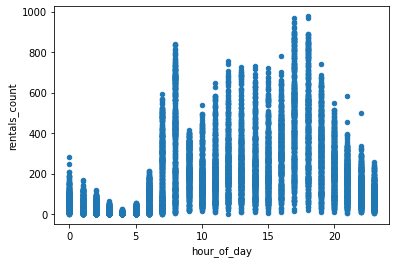

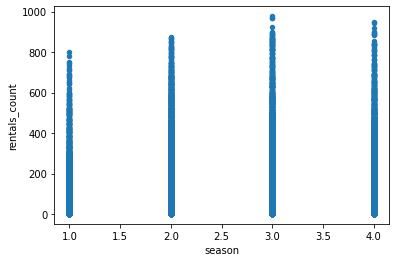

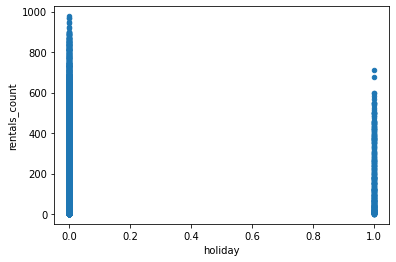

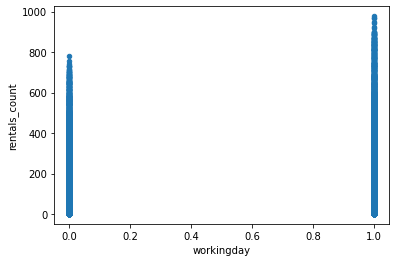

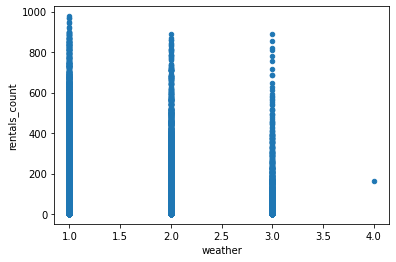

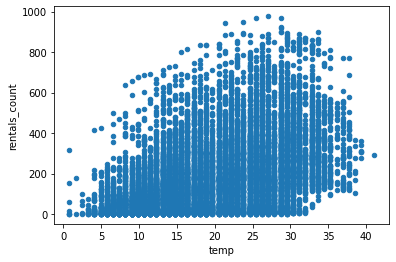

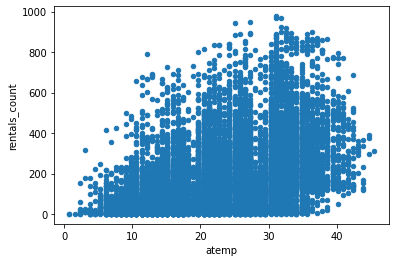

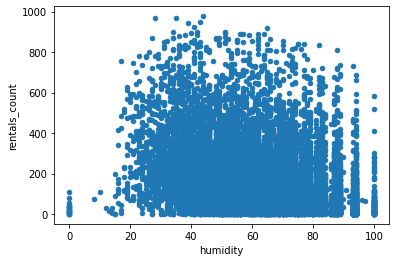

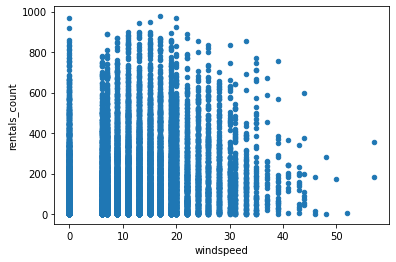

In [21]:
for feature in train_df.columns[:-1]:
    train_df.plot.scatter(feature, "rentals_count")

array([[<AxesSubplot:title={'center':'hour_of_day'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'rentals_count'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

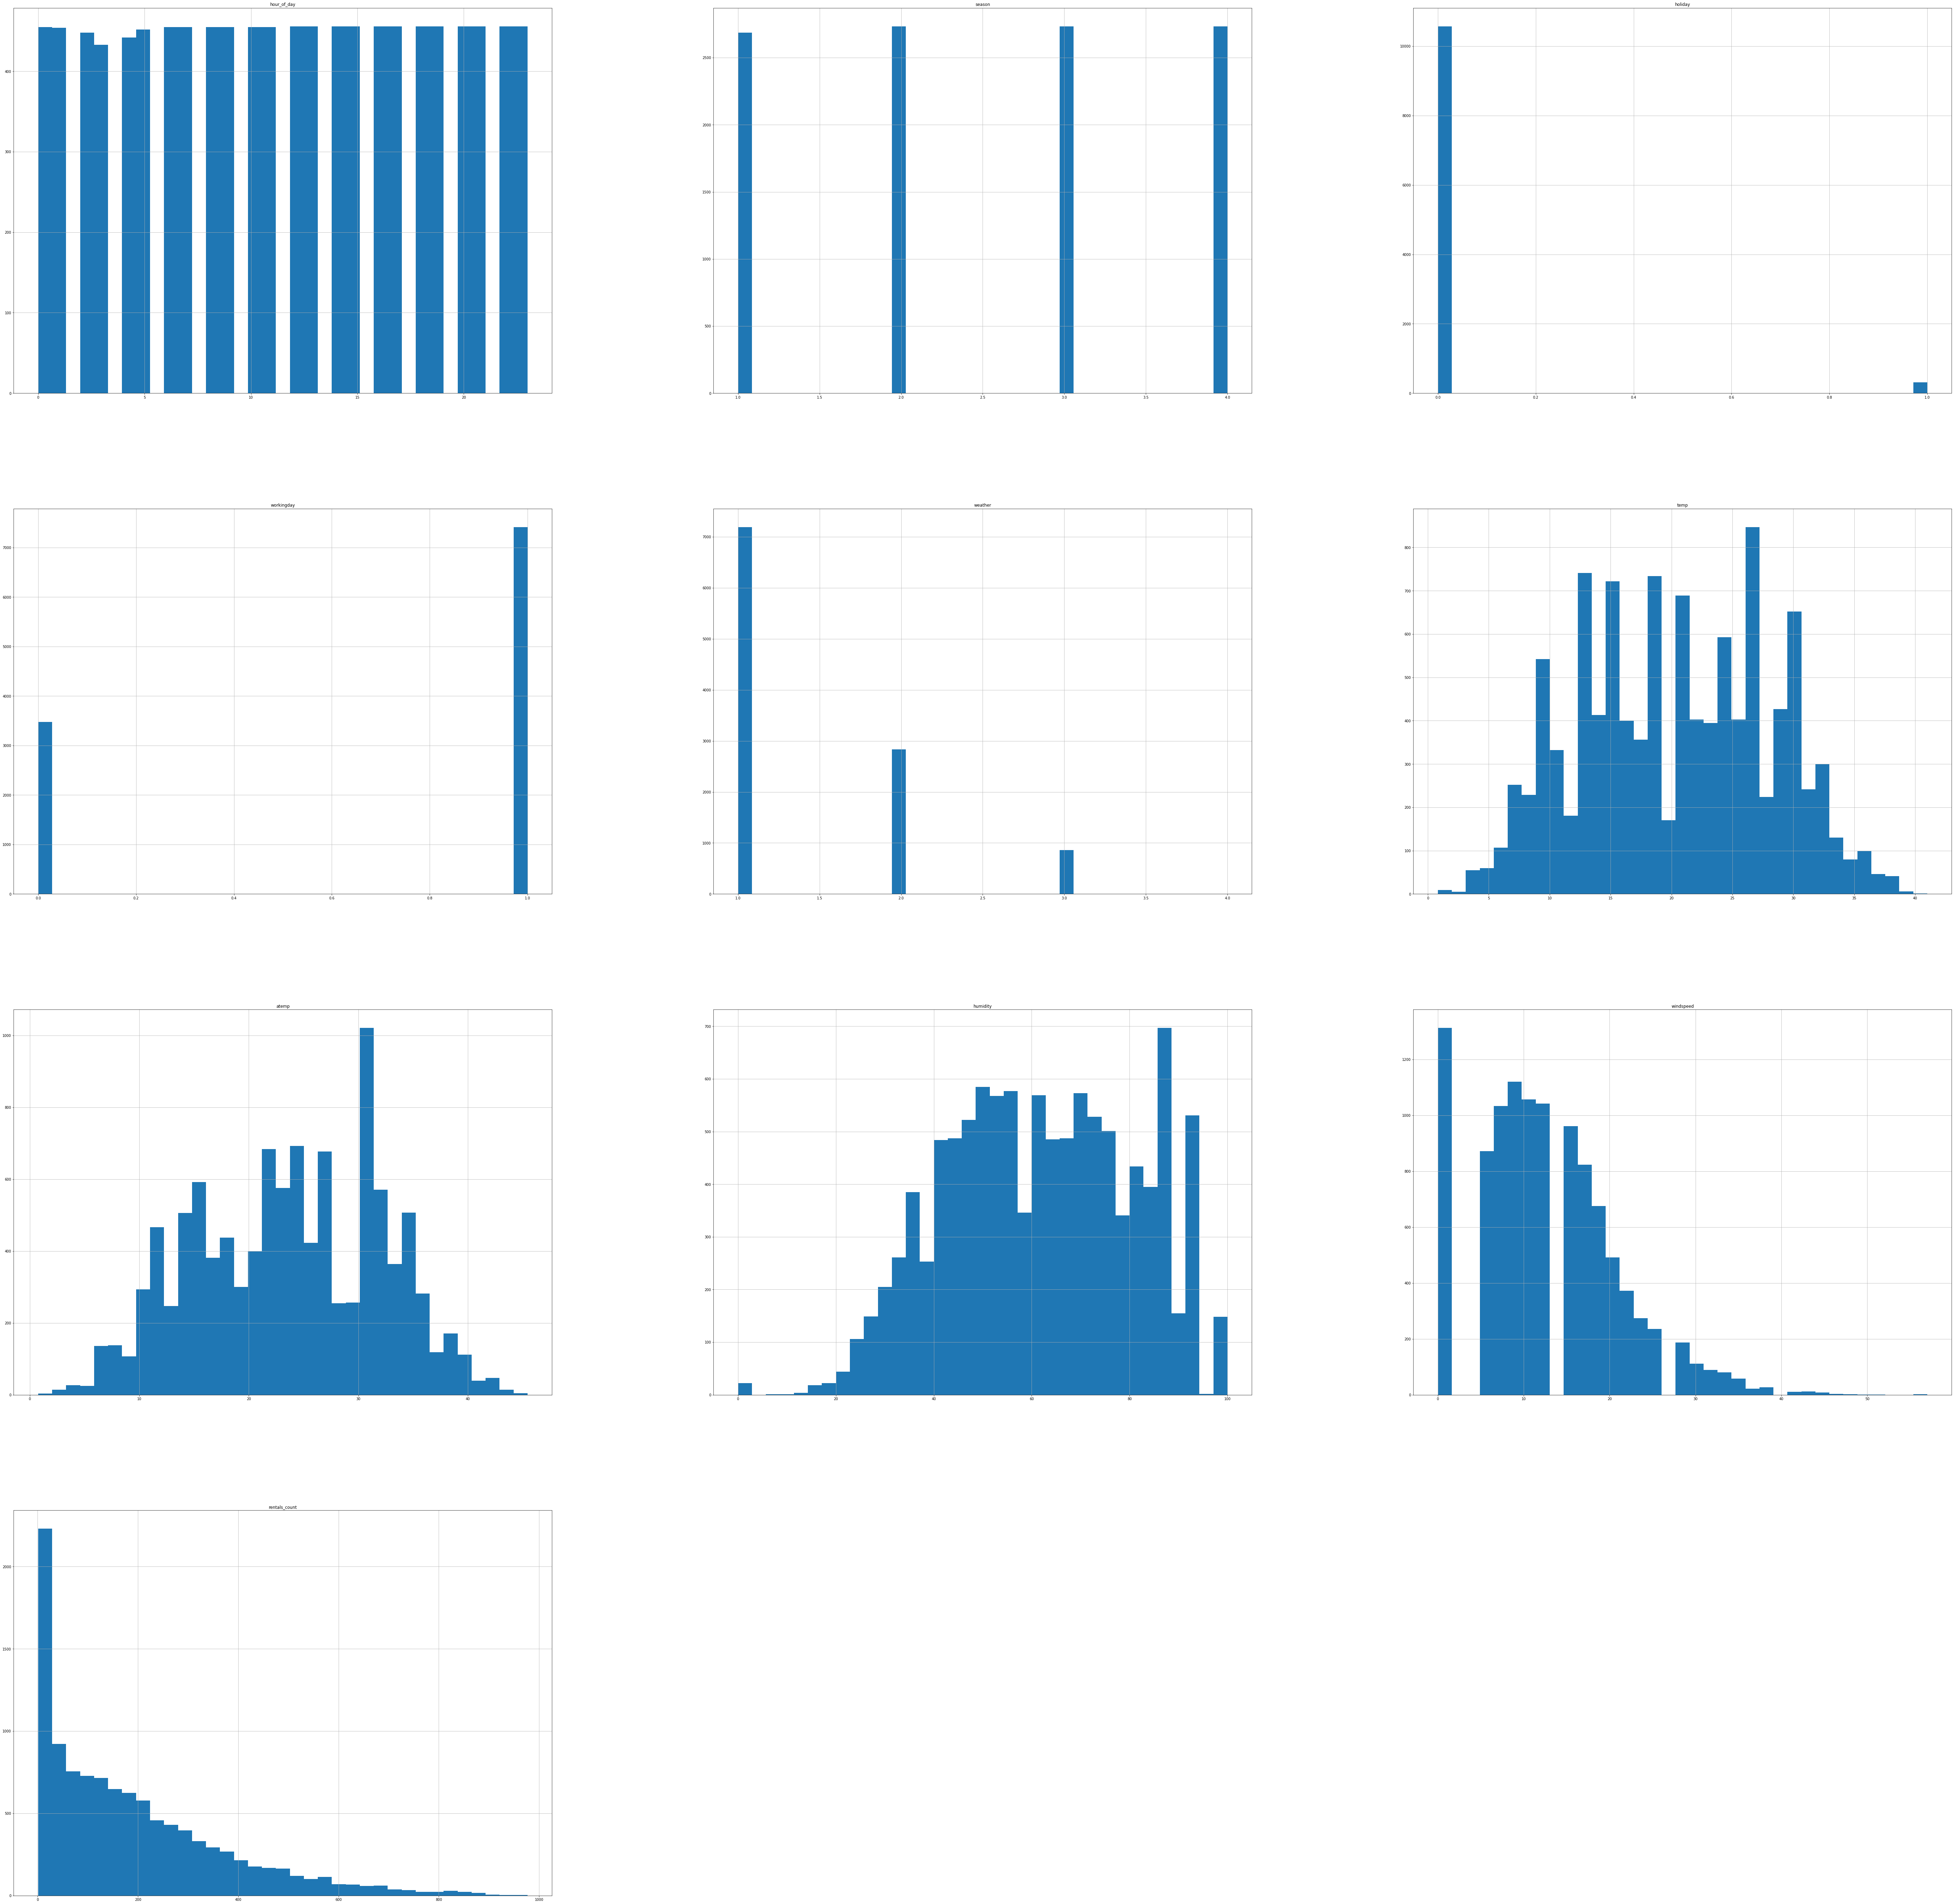

In [22]:
train_df.hist(bins=35, figsize=(100, 100))

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hour_of_day    10886 non-null  int64  
 1   season         10886 non-null  int64  
 2   holiday        10886 non-null  int64  
 3   workingday     10886 non-null  int64  
 4   weather        10886 non-null  int64  
 5   temp           10886 non-null  float64
 6   atemp          10886 non-null  float64
 7   humidity       10886 non-null  int64  
 8   windspeed      10886 non-null  float64
 9   rentals_count  10886 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 850.6 KB


In [24]:
train_df.describe()

,hour_of_day,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,rentals_count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,11.541613,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,6.915838,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,6.000000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,12.000000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,18.000000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,23.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


In [25]:
train_df.corr()

,hour_of_day,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,rentals_count
hour_of_day,1.000000,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,0.400601
season,-0.006546,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,-0.000354,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,0.002780,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,-0.022740,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.145430,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.140343,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.278011,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,0.146631,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
rentals_count,0.400601,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


From the above correlation matrix, we see that feature `temp` is highly correlated with feature `atemp`, thus why we can remove feature `atemp`.

In [26]:
train_df.drop(columns=["atemp"], inplace=True)

# Data Pre-processing

## No missing data

## No noisy data. There's a few outliers, though I'll keep them to introduce some noise to the model, preventing overfitting.

## Normalization Scaling: Within the training step itself, by setting `normalize` to `True`.

# Model Training

In [27]:
X_train = train_df.iloc[:, :-1].values
y_train = train_df['rentals_count']

model = LinearRegression(normalize=True).fit(preprocessing.PolynomialFeatures(4).fit_transform(X_train), y_train)

# Model Pickling

In [28]:
model_file = open('model.pickle', 'wb')
pickle.dump(model, model_file)
model_file.close()